# Version Updates:
- Discovered that I was using the wrong data: Cumulative infections instead of Daily New Infections
- Incorporate government stringency index into the model
    - Add a column for index values per date 
- Incorporate death
    - Every 3/100 of infected die; add this in the for loop.
- Removed gamma from the model:
    - Gamma is now an initial condition. While keep gamma as a fitting parameter generates a more accurate fit, the         fitter always assumes gamma is negative. 
- Add error and uncertainty when plotting

# Results/Analysis from previous model (Add to LateX)
- Taiwan has a lower k (transmission/spread rate) than US as expected
- How do we deal with gamma if it's always negative? 
- The SIR model may work well for shorter periods of time
    - Complex behavior of a pandemic over several months is very difficult to predict
    
# Good resource for understanding / talking about SIR model
    https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
res = requests.get(url, allow_redirects=True)
with open('time_series_covid19_confirmed_global.csv','wb') as file:
    file.write(res.content)
    
glob_data = pd.read_csv('time_series_covid19_confirmed_global.csv')


taiwan_data = glob_data[glob_data['Country/Region'] == 'Taiwan*']
taiwan_cases = taiwan_data.values.tolist()[0][4:]  # 1/22/20 start

us_data = glob_data[glob_data['Country/Region'] == 'US']
us_cases = us_data.values.tolist()[0][4:]   # 1/22/20 start

In [94]:
us_data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20
244,NaN,US,40.0,-100.0,1,1,2,2,5,5,...,8576841,8637648,8704446,8778078,8856436,8944957,9044278,9133404,9206998,9291087


In [116]:
taiwan_df = pd.DataFrame()
taiwan_df['Infected'] = taiwan_cases
days = np.arange(0,len(taiwan_df['Infected'])).tolist()
taiwan_df['Day'] = days    
taiwan_df['New Infected'] =  taiwan_df['Infected'] - taiwan_df['Infected'].shift(1)
taiwan_df['New Infected'].iloc[0] = 1
taiwan_df = taiwan_df[:-4] # Remove last 4 data points to match length of 
                                        # Taiwan's stringency index

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [117]:
us_df = pd.DataFrame()
us_df['Infected'] = us_cases
days = np.arange(0,len(us_df['Infected'])).tolist()
us_df['Day'] = days 
us_df['New Infected'] =  us_df['Infected'] - us_df['Infected'].shift(1)
us_df['New Infected'].iloc[0] = 1
us_df = us_df[:-7]

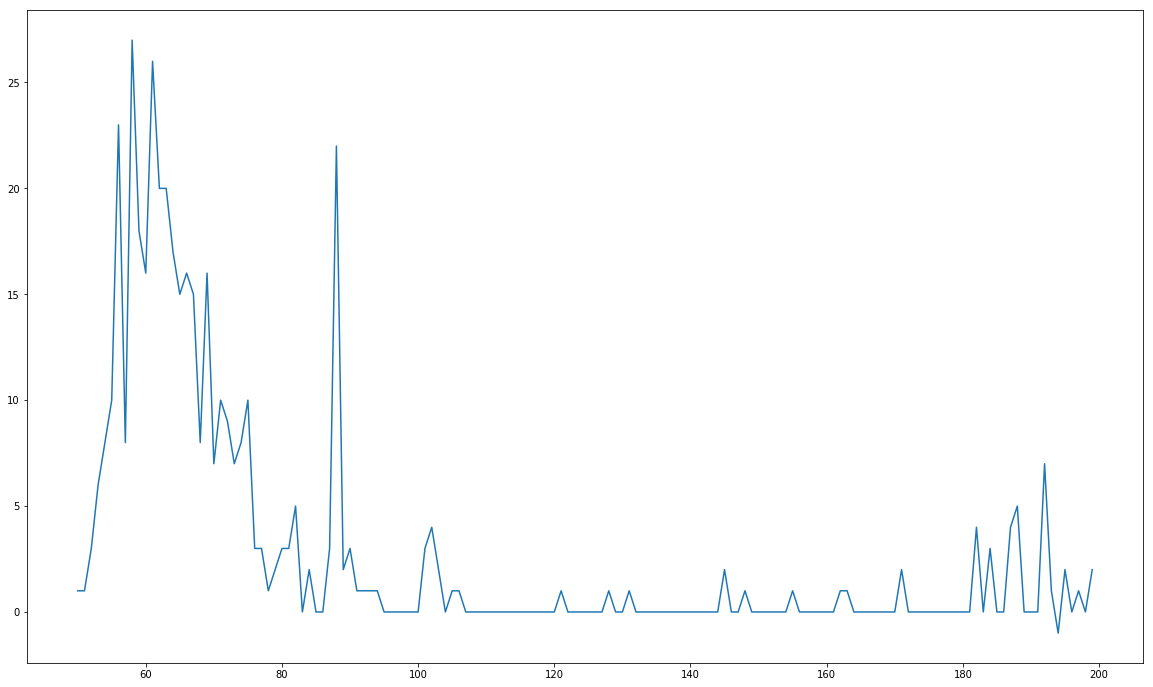

In [106]:
plt.figure(figsize=(20,12))
plt.plot(taiwan_df['Day'], taiwan_df['New Infected'])

# Let's add government stringency

In [97]:
#string_df = pd.read_csv(os.path.expanduser("~/Desktop/covid-stringency-index.csv"))
#taiwan_stringency = string_df.loc[string_df['Entity'] == 'Taiwan'].reset_index().iloc[21:]
#taiwan_df['S'] = taiwan_stringency['Stringency Index (OxBSG)'].values.tolist()
#us_stringency = string_df.loc[string_df['Code'] == 'USA'].reset_index().iloc[21:]
#us_df['S'] = us_stringency['Stringency Index (OxBSG)'].values.tolist()

# Re-writing the SIR Model


In [118]:
def I_model(t, k, gamma, pop): # Dont fit gamma
   # gamma = 1/18 # I need to make this an initial condition. This fails horribly when fitting
    xplot=[0]
    N = pop
    h = 1 # steps
    I = [1] # Initial infections always start at 1 
    S = [N-3]  # N-3 initially susceptible
    R = [0] # 0 recovered initially
    D = [0] # initial deaths
    deathrate = 0.0257046941 # global deathrate
    for i in t:
        x = xplot[i]
        
        
        kS1 = -k*S[i]*I[i]/N      
        kI1 = k*S[i]*I[i]/N - gamma*I[i] 
        kR1 = gamma*I[i]
     #   kD1 = mu*I[i]
        
        yS = S[i] + h*kS1
        yI = I[i] + h*kI1
        yR = R[i] + h*kR1
     #   yD = D[i] + h*kD1
        
        xplot.append(x+h)
        S.append(yS)
        I.append(yI)
        R.append(yR)   # Removed ~ 
     #   D.append(yD)
        
    return I[:-1]

def death_model(t,k,gamma,mu,pop):
    xplot=[0]
    N = pop
    h = 1 # steps
    I = [1] # Initial infections always start at 1 
    S = [N-3]  # N-3 initially susceptible
    R = [0] # 0 recovered initially
    D = [0] # initial deaths
    deathrate = 0.0257046941 # global deathrate
    for i in t:
        x = xplot[i]
        
        
        kS1 = -k*S[i]*I[i]/N      
        kI1 = k*S[i]*I[i]/N - gamma*I[i] 
        kR1 = gamma*I[i]
        kD1 = mu*I[i]
        
        yS = S[i] + h*kS1
        yI = I[i] + h*kI1
        yR = R[i] + h*kR1
        yD = D[i] + h*kD1
        
        xplot.append(x+h)
        D.append(yD)
        I.append(yI)
        R.append(yR)
        S.append(yR)
        
    return D[:-1]    



In [119]:
us_df = us_df[0:100]
taiwan_df = taiwan_df[0:100]


# Fitting 100 days of US Daily Infection Data

N = 45820.5692183592 +/- 3262.512314788672
US: Best values for k:  0.1897 +/- 0.0029
US: Best values for gamma:  0.018 +/- 0.004
US: mean squared error between fit and data: 4332548.542131695
US: chi squared error between fit and data: Power_divergenceResult(statistic=43802.27689740168, pvalue=0.0)


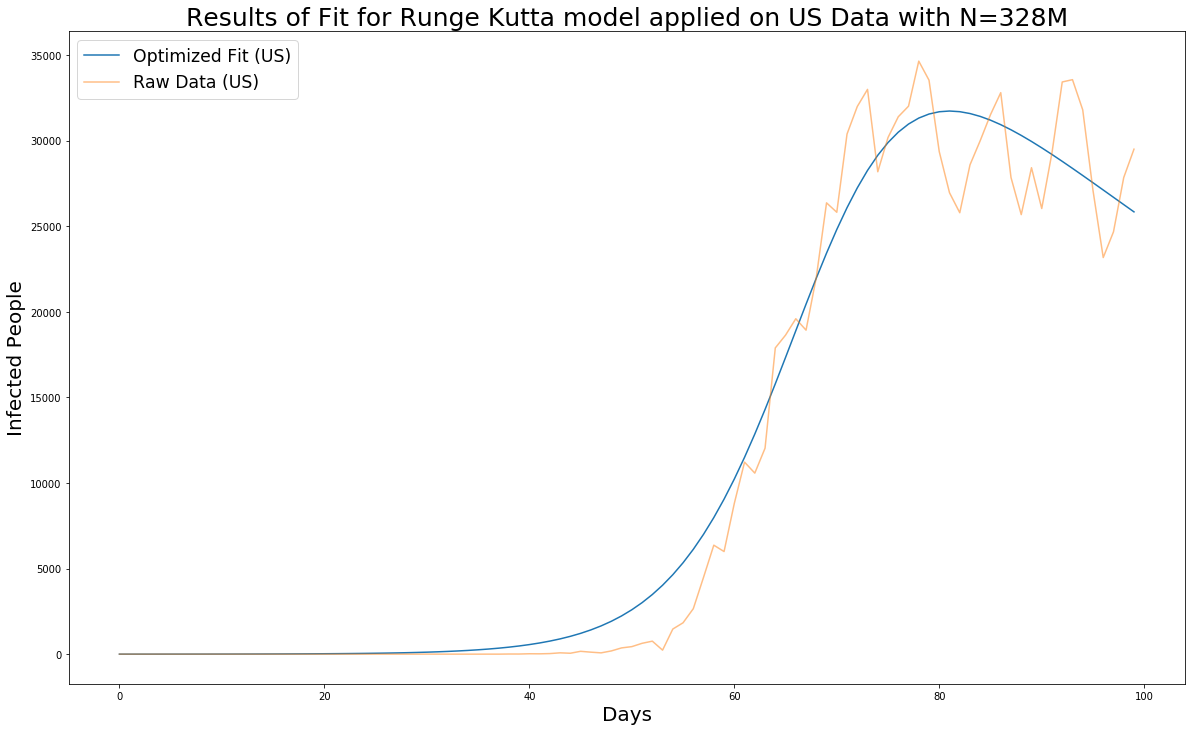

In [122]:
from scipy.optimize import curve_fit   # our main fitting optimizer (reduces error while finding best fit)
from scipy import optimize
from sklearn.metrics import mean_squared_error
from scipy import stats

par, cov = optimize.curve_fit(I_model, us_df['Day'], us_df['New Infected'], 
                                               p0=[2/14, 0.01, 328000000], bounds=(0, [100, 100, 328000000]), maxfev=5000)

pred1= I_model(us_df['Day'], par[0], par[1], par[2])
target1=us_df['New Infected']
print("N =", par[2], "+/-", (np.sqrt(np.diag(cov))[2]))
y1= mean_squared_error(target1, pred1)



print("US: Best values for k: ", round(par[0],4), "+/-", round(np.sqrt(np.diag(cov))[0],4))
print("US: Best values for gamma: ", round(par[1],4), "+/-", round(np.sqrt(np.diag(cov))[1],3))

print("US: mean squared error between fit and data:", y1)
chi1 = stats.chisquare(f_obs = target1, f_exp = pred1)
print("US: chi squared error between fit and data:", chi1)


plt.figure(figsize=(20,12))
plt.plot(us_df['Day'], pred1, label="Optimized Fit (US)", alpha=1.0)
plt.plot(us_df['Day'], us_df['New Infected'], label='Raw Data (US)', alpha = 0.5)

plt.title("I(t) fitted on US Data with N=328M", fontsize=25)
plt.xlabel("Days", fontsize = 20)
plt.ylabel("Infected People", fontsize = 20)
plt.legend(loc='best')
plt.legend(fontsize="xx-large")

plt.show()

# Plotting the spread / uncertainty of the model

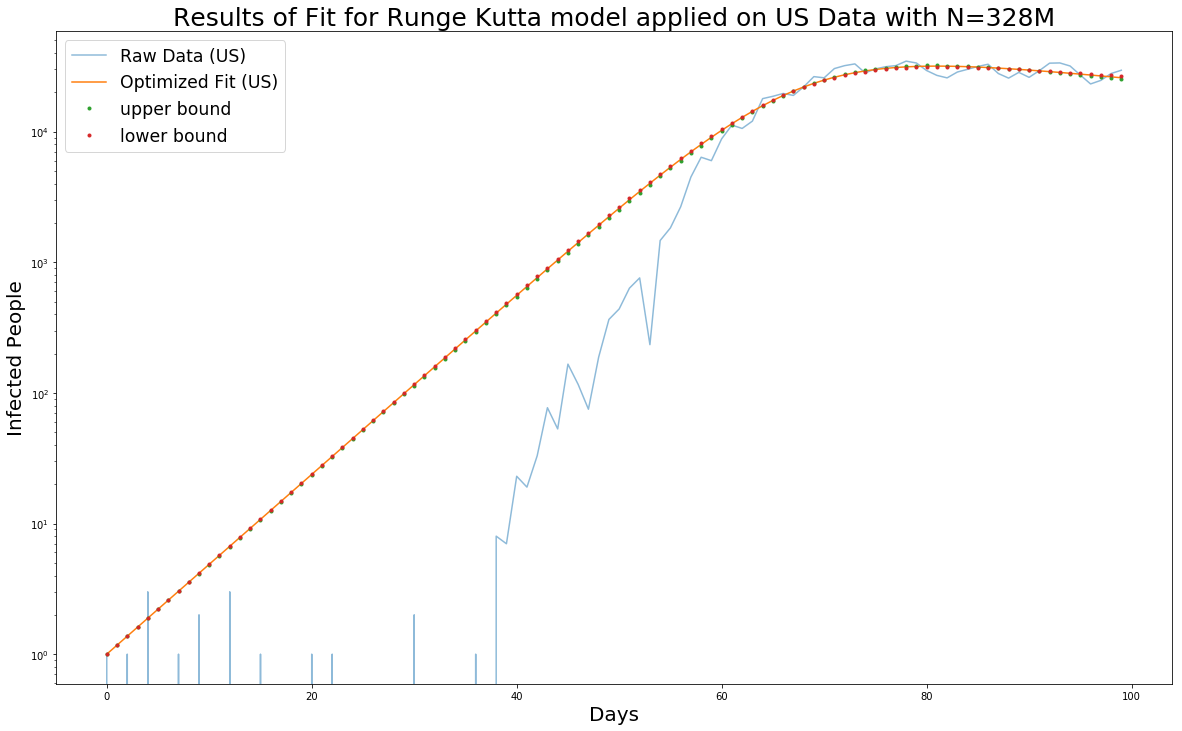

In [126]:
pred1= I_model(us_df['Day'], par[0], par[1], par[2])
upper_pred = I_model(us_df['Day'], par[0]+np.sqrt(np.diag(cov))[0], par[1]+np.sqrt(np.diag(cov))[1], 
                     par[2]+np.sqrt(np.diag(cov))[2])
lower_pred = I_model(us_df['Day'], par[0]-np.sqrt(np.diag(cov))[0], par[1]-np.sqrt(np.diag(cov))[1], 
                     par[2]-np.sqrt(np.diag(cov))[2])

plt.figure(figsize=(20,12))

plt.plot(us_df['Day'], us_df['New Infected'], label='Raw Data (US)', alpha = 0.5)

plt.plot(us_df['Day'], pred1, label="Optimized Fit (US)", alpha=1.0)
plt.plot(us_df['Day'],upper_pred, '.', label='upper bound')
plt.plot(us_df['Day'],lower_pred, '.',label='lower bound')

plt.yscale('log')
plt.title("Results of Fit for Runge Kutta model applied on US Data with N=328M", fontsize=25)
plt.xlabel("Days", fontsize = 20)
plt.ylabel("Infected People", fontsize = 20)
plt.legend(loc='best')
plt.legend(fontsize="xx-large")

plt.show()

# Fitting first 100 days of US Death Data

In [102]:
url2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
res2 = requests.get(url2, allow_redirects=True)
with open('time_series_covid19_deaths_global.csv','wb') as file:
    file.write(res2.content)
    
death_data = pd.read_csv('time_series_covid19_deaths_global.csv')


taiwan_death = glob_data[glob_data['Country/Region'] == 'Taiwan*']
taiwan_death = taiwan_data.values.tolist()[0][4:]  # 1/22/20 start

us_death = glob_data[glob_data['Country/Region'] == 'US']
us_death = us_data.values.tolist()[0][4:]   # 1/22/20 start


us_death_df = pd.DataFrame()
us_death_df['Deaths'] = us_death
days = np.arange(0,len(us_death_df['Deaths'])).tolist()
us_death_df['Day'] = days    
us_death_df['New Deaths'] =  us_death_df['Deaths'] - us_death_df['Deaths'].shift(1)
us_death_df['New Deaths'].iloc[0] = 1


taiwan_death_df = pd.DataFrame()
taiwan_death_df['Deaths'] = taiwan_death
days = np.arange(0,len(taiwan_death_df['Deaths'])).tolist()
taiwan_death_df['Day'] = days    
taiwan_death_df['New Deaths'] =  taiwan_death_df['Deaths'] - taiwan_death_df['Deaths'].shift(1)
taiwan_death_df['New Deaths'].iloc[0] = 1

taiwan_death_df = taiwan_death_df[0:100]
us_death_df = us_death_df[0:100]

In [103]:
x = death_model(us_death_df['Day'], 2/14, 0.01, 0.0257046, 328000000)

N = 327615338.7520431
US: Best values for k:  7.2065 +/- 569.1781
US: Best values for gamma:  0.0015 +/- 0.001
US: Best values for deathrate:  32.8143 +/- 2271.9497
US: mean squared error between fit and data: 148696703.53605345
US: chi squared error between fit and data: Power_divergenceResult(statistic=inf, pvalue=0.0)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:4653: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


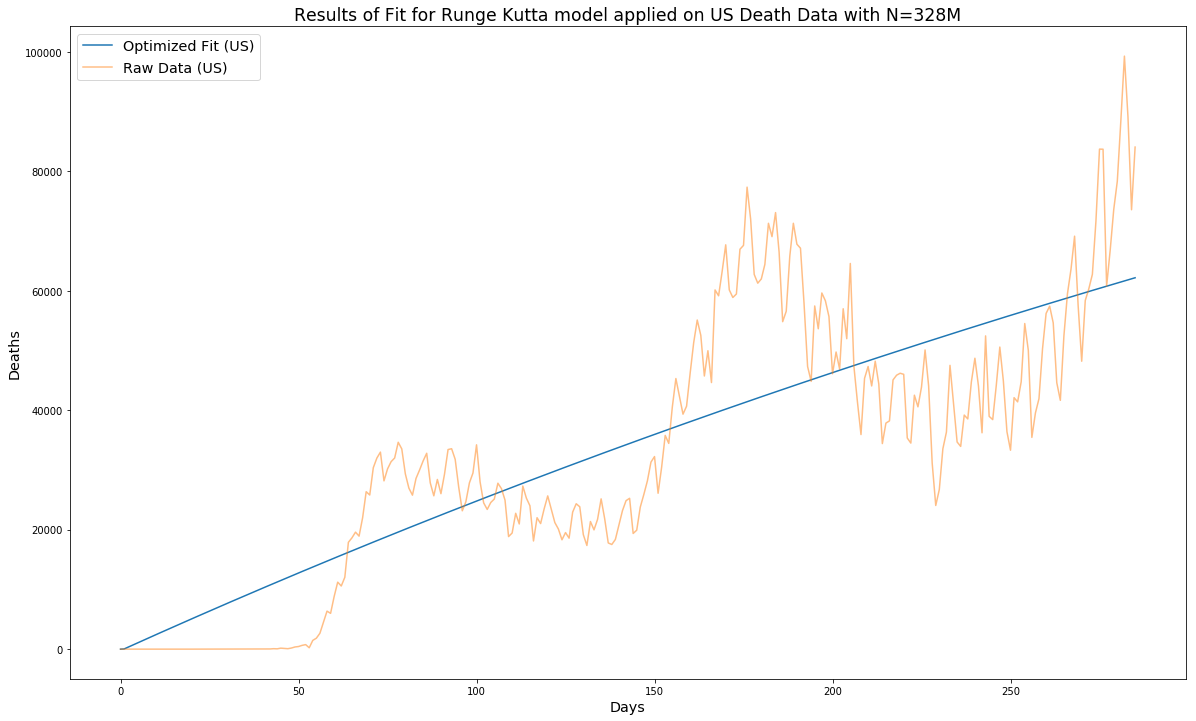

In [69]:
par2, cov2 = optimize.curve_fit(death_model, us_death_df['Day'], us_death_df['New Deaths'], 
                                               p0=[2/14, 0.01, .0257046941, 328000000], bounds=(0, [100, 100, 100, 328000000]), maxfev=5000)

pred2= death_model(us_death_df['Day'], par2[0], par2[1], par2[2], par2[3])
target2=us_death_df['New Deaths']
print("N =", par2[3])
y2= mean_squared_error(target2, pred2)



print("US: Best values for k: ", round(par2[0],4), "+/-", round(np.sqrt(np.diag(cov2))[0],4))
print("US: Best values for gamma: ", round(par2[1],4), "+/-", round(np.sqrt(np.diag(cov2))[1],3))
print("US: Best values for deathrate: ", round(par2[2],4), "+/-", round(np.sqrt(np.diag(cov2))[2],4))

print("US: mean squared error between fit and data:", y2)
chi2 = stats.chisquare(f_obs = target2, f_exp = pred2)
print("US: chi squared error between fit and data:", chi2)


plt.figure(figsize=(20,12))
plt.plot(us_death_df['Day'], pred2, label="Optimized Fit (US)", alpha=1.0)
plt.plot(us_death_df['Day'], us_death_df['New Deaths'], label='Raw Data (US)', alpha = 0.5)

plt.title("Results of Fit for Runge Kutta model applied on US Death Data with N=328M", fontsize="xx-large")
plt.xlabel("Days", fontsize = "x-large")
plt.ylabel("Deaths", fontsize = "x-large")
plt.legend(loc='best')
plt.legend(fontsize="x-large")

plt.show()

# Fitting first 100 days of Taiwan Infection Data

N = 3881736.5041716555
Taiwan: Best values for k:  27.3012 +/- 1125.2817
Taiwan: Best values for gamma:  27.2457 +/- 1125.3003
Taiwan: mean squared error between fit and data: 29.224086213407844
Taiwan: chi squared error between fit and data: Power_divergenceResult(statistic=434.4440681606579, pvalue=1.4880312943118036e-43)


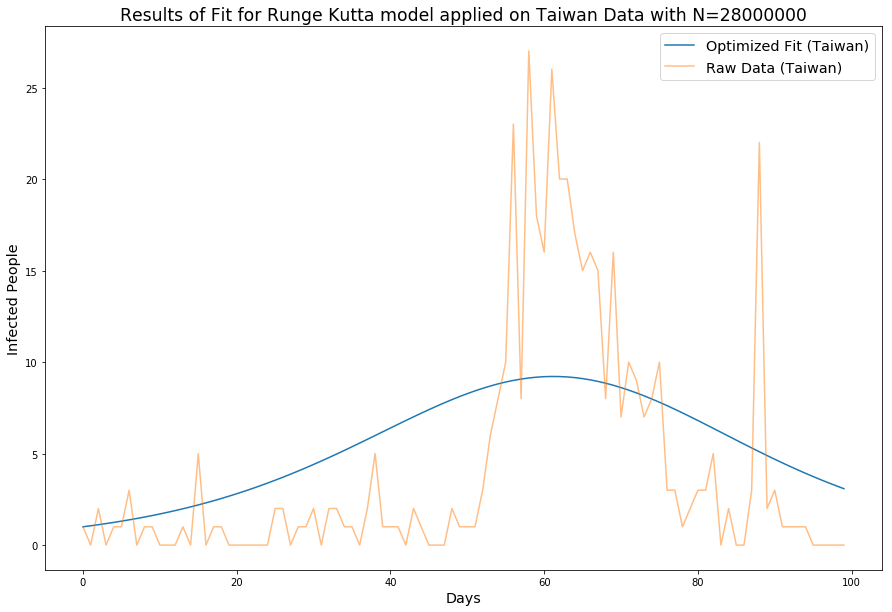

In [70]:
params, params_covariance = optimize.curve_fit(SIR_model, taiwan_df['Day'], taiwan_df['New Infected'], 
                                               p0=[1/14, 0.03, 28000000], bounds=(0, [100, 100, 28000000]), maxfev=5000)

prediction = SIR_model(taiwan_df['Day'], params[0], params[1], params[2])
target = taiwan_df['New Infected']
print("N =", params[2])

y = mean_squared_error(target, prediction)

print("Taiwan: Best values for k: ", round(params[0],4), "+/-", round(np.sqrt(np.diag(params_covariance))[0],4))
print("Taiwan: Best values for gamma: ", round(params[1],4), "+/-", round(np.sqrt(np.diag(params_covariance))[1],4))

print("Taiwan: mean squared error between fit and data:", y)
chi = stats.chisquare(f_obs = target, f_exp = prediction)
print("Taiwan: chi squared error between fit and data:", chi)

plt.figure(figsize=(15,10))
plt.plot(taiwan_df['Day'], prediction, label="Optimized Fit (Taiwan)", alpha=1.0)
plt.plot(taiwan_df['Day'], taiwan_df['New Infected'], label='Raw Data (Taiwan)', alpha = 0.5)
plt.title("Results of Fit for Runge Kutta model applied on Taiwan Data with N=28000000", fontsize="xx-large")
plt.xlabel("Days", fontsize = "x-large")
plt.ylabel("Infected People", fontsize = "x-large")
plt.legend(loc='best')
plt.legend(fontsize="x-large")
plt.show()